In [16]:
import sys
sys.path.append('e:\solar flares\data\\2017-09-06')


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import use_nessi as un
import use_nessi2 as un2
# import os
from importlib import reload

# from matplotlib import cm
# import matplotlib.cbook as cbook
# import matplotlib.colors as colors
# from scipy.interpolate import interp1d
from PIL import Image
from matplotlib import transforms



sr = solar_radius = 959.63
area_factor = 60**2/np.pi/sr**2

In [18]:
import scipy

    
def get_data(lines):
    data = un.load_for_further_analysis(lines, un.get_full_path(lines[0]))
    for line in lines:
        if "CaK" in line:
            un2.disgard_cont_point(line, data)
    
    return data 

def index_match(lines, name):
    for i, line in enumerate(lines):
        if line in name:
            return i
    raise IndexError(f'No line in lines (={lines}) matches {name}. ')
    
def ax_contr(wav, time, DFD, name, line, ax, fig):
        W, T = np.meshgrid(wav, time)
        print("scaled flare: Line", name)

        un2.ax_contrastplot(fig, ax, W, T, DFD, wav, line, decorations={}, seperate_colorbar=True, vlim=None)
        
def Full_line_ana(fig, ax, names_of_lines_list, scalefactor, name_of_flare='', name_of_show_line=None, data=None):
    if data is None:
        data = get_data(names_of_lines_list)
    for i, name in enumerate(names_of_lines_list):
        wav, DFD , time, line, std = un2.contrast_FD_data(name,data, quiet_sun_subtraction=False, 
                                                          area_factor=area_factor*scalefactor, add_noise=False)
        params, voigt, res = load_voigt_data(name, wav)
        ax_contr(wav, time, DFD, name, line, ax[0, i], fig)
        c = area_factor*scalefactor
        ax_visualize_analysis(ax[1, i], c*res, c*voigt, wav, time, name)

    plot_DEW(ax[0, -1], data, names_of_lines_list, scalefactor)
    if name_of_show_line is None:
        name_of_show_line = names_of_lines_list[0]
    ax_mu_frame(ax[1, -1], name_of_show_line)

    ax[0, 0].set_ylabel(f"NESSI-FD = ({scalefactor}x Scaled FOV + NESSI profile) ")
    ax[1, 0].set_ylabel("Residues (colormap) of voigt (contour) fit to FD.")
    
    in_latex_fig(name_of_flare, names_of_lines_list, scalefactor)
    
def color_for_name(name):
    colors = {'Ha':'red', 'CaK':'blue', 'CaI':"yellow", "Fe":"darkgreen", "Hbeta":"purple"}
    for line in colors:
        if line in name:
            return colors[line]
    raise ValueError(f'The given name {name} is not linked to a color yet.')

def plot_DEW(ax, data, names, scalefactor):
    under_bound=0
    for name in names:
        dew, time = DEW(data, name, scalefactor)
        dew = np.array(dew)
        scale = round(np.log(max(np.max(dew), -np.min(dew)))/np.log(10)) if len(names)>1 else 0
        ax.plot(
            time,
            dew / (10**scale),
            '-o',
            color='black',
            markerfacecolor=color_for_name(name),
            markeredgewidth=0.5,
            markersize=5,
            label=f"""{latex_name(name)}{f", x10^{str(scale)}" if scale != 0 else ''}""",
        )
        under_bound = min(np.percentile(dew/10**scale, 2), under_bound)
    ax.set_title(r'Time evolution of the $\Delta EW $ with $\Delta \lambda = 0.5 \AA$. ')
    ax.set_xlabel('Time from begin of flare [min]')
    ax.set_ylabel(r'$\Delta EW$ $[\AA]$')
    if under_bound<0:
        ax.set_ylim(bottom=under_bound, top=None)  # Set top to None to avoid automatic adjustment
    ax.legend()

def DEW(data, name, scalefactor=1, Dlambda=0.5):
    sr = 959.63
    area_factor= 60**2/np.pi/sr**2*scalefactor
    
    wav, DFD , time, line, std = un2.contrast_FD_data(name,data, quiet_sun_subtraction=False, area_factor=area_factor,
                                                      add_noise=False)

    line_center = wav[np.where(line == np.min(line))[0][0]]
    interval = [line_center-Dlambda, line_center+Dlambda]
    
    DEW = []

    for frame in range(np.shape(time)[0]):
        

        x, restx = un.restrict_intervalx2(interval, wav)
        # print(np.shape(x), np.shape(restx(DFD)), x, DFD[frame] )

        DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))

    return DEW, time

def gaussian(x, amp_g, cen_g, sigma_g):
    """Gaussian function."""
    return amp_g * np.exp(-(x - cen_g)**2 / (2 * sigma_g**2))

def lorentzian(x, amp_l, cen_l, gamma_l):
    """Lorentzian function."""
    return amp_l * (gamma_l**2 / ((x - cen_l)**2 + gamma_l**2))

def voigt(x, param, offset=0):
    """Voigt profile: approximation by combining Gaussian and Lorentzian."""
    amp_v, cen_v, sigma_v, gamma_v = param
    f_g = sigma_v**2 / (sigma_v**2 + gamma_v**2)
    return (f_g * gaussian(x, 1, cen_v, sigma_v) +
            (1 - f_g) * lorentzian(x, 1, cen_v, gamma_v)) * amp_v + offset

def load_voigt_data(name, wav):
    fname = f"E:/solar flares/data/voigt_fitting/fit_data/voigt_data_{name}.npz"
    data =  np.load(fname) 
    params = data['arr_0']
    res = data["arr_1"]
    voigt_data= np.array([ voigt(wav, param[0]) for param in params]) 
    return params, voigt_data, res    

def latex_name(name):
    names = {"Ha":r"H$\alpha$", "CaK":r'Ca$IIK$', "CaIR":r'Ca$II 8542 \AA$', "Fe6173":r'Fe $6173 \AA$', "Hbeta":r'H$\beta$', "CaK(2)":r'Ca$II 3968 \AA$'}
    el = un2.element_from_name(name)
    try:
        return names[el]
    except:
        raise ValueError(f"Name {names} is not found in the keys {names.keys()}.")

def cut_off_data(data, up_lim=None, down_lim=None):
    if up_lim is None and down_lim is None:
        up_lim = max(-np.percentile(data, 3), np.percentile(data, 97))
        down_lim = - up_lim
    elif up_lim is None:
        up_lim = np.percentile(data, 97)
    elif down_lim is None:
        down_lim = np.percentile(data, 3)
    # Apply cutoff using boolean indexing and conditional assignment
    cutoff_data = np.where(data > up_lim, up_lim, data)
    cutoff_data = np.where(data < down_lim, down_lim, cutoff_data)
    return cutoff_data

def replace_outliers(data, nsigma):
  """
  Detects outliers in a NumPy array and replaces them with the 2 sigma value in their direction.

  Args:
      data: A 1D NumPy array.

  Returns:
      A new 1D NumPy array with outliers replaced by 2 sigma values.
  """

  # Calculate mean and standard deviation
  med = np.median(data)
  std = np.std(data)

  # Define 2 sigma threshold (both upper and lower)
  lower_bound = med - nsigma * std
  upper_bound = med + nsigma * std

  data_replaced = np.where(data > lower_bound, data, lower_bound)
  data_replaced = np.where(data < upper_bound, data_replaced, upper_bound)

  return data_replaced

def ax_visualize_analysis(ax, res, voigt_data, wav, time, name, non_centered=True):
    el = un2.element_from_name(name)
    print("plotting element", el, "name:", name)
    if el in ["Fe6173", "CaIR", "Ha"]:
        if non_centered:
            vmax = np.percentile(res, 97)
            vmin = np.percentile(res, 3)
        else:
            vmax = max(-np.percentile(res, 3), np.percentile(res, 97))
            vmin =-vmax
            
        if "19" in name:
            print("the special flare")
            # vmin = np.percentile(res, 3)
            voigt_data= replace_outliers(voigt_data, 2)
        print(f"{vmax = }, {vmin = }")
        c = ax.imshow(np.array(res), aspect="auto", cmap='RdBu_r', origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]),
                    vmax=vmax, vmin=vmin)

    else:
        c = ax.imshow(np.array(res), aspect="auto", cmap='RdBu_r', origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]))
    # pcm = ax.pcolormesh(X, Y, Z, cmap='RdBu_r',vmin=-np.max(Z),  shading='auto')
    cb = fig.colorbar(c, ax=ax, extend='both')
    X, Y = np.meshgrid(wav, time)
    CS = ax.contour(X, Y, voigt_data, colors='black', alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10) 
    # ax.set_xlabel(r"Wavelength [$\AA$]")
    # cb.set_label(r'the residues after Voigt fit [relative intensity]')

def load_mu_frame(name):
    data = np.load(f"{un.get_full_path(name)}/line_data/contourdata{name}.npz")
    x = data["arr_1"]
    y = data["arr_2"]
    X, Y = np.meshgrid(x, y)
    ccp = data["arr_3"]
    extent = (np.min(x), np.max(x), np.min(y), np.max(y))
    rotation = data.get("arr_4", 0)
    MU, X, Y = square_full_mu_mesh(X, Y, angle=rotation)
    return MU, X, Y, ccp, extent, rotation

def square_full_mu_mesh(X,Y, angle, num=200):
    X = np.array([np.min(X), np.max(X)])
    Y = np.array([np.min(Y), np.max(Y)])
    X,Y = np.meshgrid(X,Y)
    X,Y = rotate_mesh_around_average(X,Y, angle)
    X = np.linspace(np.min(X), np.max(X), num)
    Y = np.linspace(np.min(Y), np.max(Y), num)
    X,Y = np.meshgrid(X,Y)
    MU = calculate_mu(X,Y)
    return MU, X, Y

def calculate_mu(x,y, radius=959.63):
    rad_dist =  (x**2 + y**2)**0.5/radius
    return np.cos(np.arcsin(rad_dist))

def rotate_mesh_around_average(xx, yy, angle):
  # Calculate the average x and y coordinates
  avg_x = np.mean(xx)
  avg_y = np.mean(yy)

  # Shift the mesh to center it around the average
  xx_centered = xx - avg_x
  yy_centered = yy - avg_y

  # Rotate the centered mesh coordinates
  xx_rot = np.cos(angle) * xx_centered -np.sin(angle) * yy_centered  + avg_x
  yy_rot = np.sin(angle) * xx_centered + np.cos(angle) * yy_centered + avg_y

  return xx_rot, yy_rot

def local_rotation(extent, rad_rot):
    mid = extent2mid(extent)
    x = np.array(mid) 
    R = np.array([[np.cos(rad_rot), -np.sin(rad_rot)], [np.sin(rad_rot), np.cos(rad_rot)]])
    y = np.dot(R, x)
    t = x-y
    return transforms.Affine2D().rotate_deg(rad_rot/np.pi*180).translate(t[0], t[1])

def extent2mid(extent):
    return ((extent[0]+extent[1])/2, (extent[2]+extent[3])/2)


def ax_mu_frame(ax, name):
    MU, X, Y, ccp, extent, rotation = load_mu_frame(name)
    
    tr = local_rotation(extent, rotation)
    ax.imshow(Image.fromarray(ccp), transform=tr + ax.transData, origin='lower', extent=extent)
    CS = ax.contour(X, Y, MU)
    ax.clabel(CS, inline=True, fontsize=10)
    ax.set_title(r'Contour plot of the $\mu$ values.')
    ax.set_xlabel('x-coordinate [arcsec]')
    ax.set_ylabel('y-coordinate [arcsec]')
   
def bold(str):
    return "\\textbf{"+str+"}"

def cmd_name(name):
    names = {"Ha":r"\Halpha", "CaK":'\\CaK', "CaIR":'\\CaIR', "Fe6173":'\\Fe{6173}', "Fe6302":'\\Fe{6302}', 
             "Hbeta":r'\Hbeta'}
    el = un2.element_from_name(name)
    try:
        return names[el]
    except:
        raise ValueError(f"Name {names} is not found in the keys {names.keys()}.")
    
def opsomming(ls_str):
    k = len(ls_str) 
    if k == 1:
        return ls_str[0]
    elif k == 2:
        return f"{ls_str[0]} and {ls_str[1]}"
    elif k>2:
        return f'{ls_str[0]}, {opsomming(ls_str[1:])}'
    else:
        raise IndentationError(' something here is not correct cannot be empty of else;..; poisjfmlksfj')
    
def no_or_pos(n):
    return f' {n}' if n > 1 else ""

def give_descr(title, lines, scalefactor):
    return f"""
    {bold(f'The full {title}:')} NESSI calculated full disk profiles 
    for ~{round(1/scalefactor * 100)}\\% flare capture. {bold(f'Upper left{no_or_pos(len(lines))}:')} 
    Contrastprofiles to the quiet sun for the lines {opsomming([cmd_name(line) for line in lines])}.
    {bold(f'Lower left{no_or_pos(len(lines))}:')} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. {bold('upper right:')}  
    Differential Equivalent Width of the available lines as a function of time. {bold('Lower right:')} A cocoplot 
    of the FOV in the {cmd_name(lines[0])} line overlayed with contour lines of the $\mu$-value. 
    """
def bracket(str):
    return "{" + str + "}"

def in_latex_fig(title, lines, scalefactor):
    env = f'''
    \\begin{ bracket('figure*')}
        \centering
        \includegraphics[width=1\linewidth]{bracket(f'Full_analysis_plots/{title}')}
        \caption{bracket(give_descr(title, lines, scalefactor)) }
        \label{bracket(f'fig:{title[12:16]}')}
    \end{bracket('figure*')}
    '''
    print(env)


# 2014 flare

FileNotFoundError: [Errno 2] No such file or directory: 'E:/solar flares/data/voigt_fitting/fit_data/voigt_data_Ha14.npz'

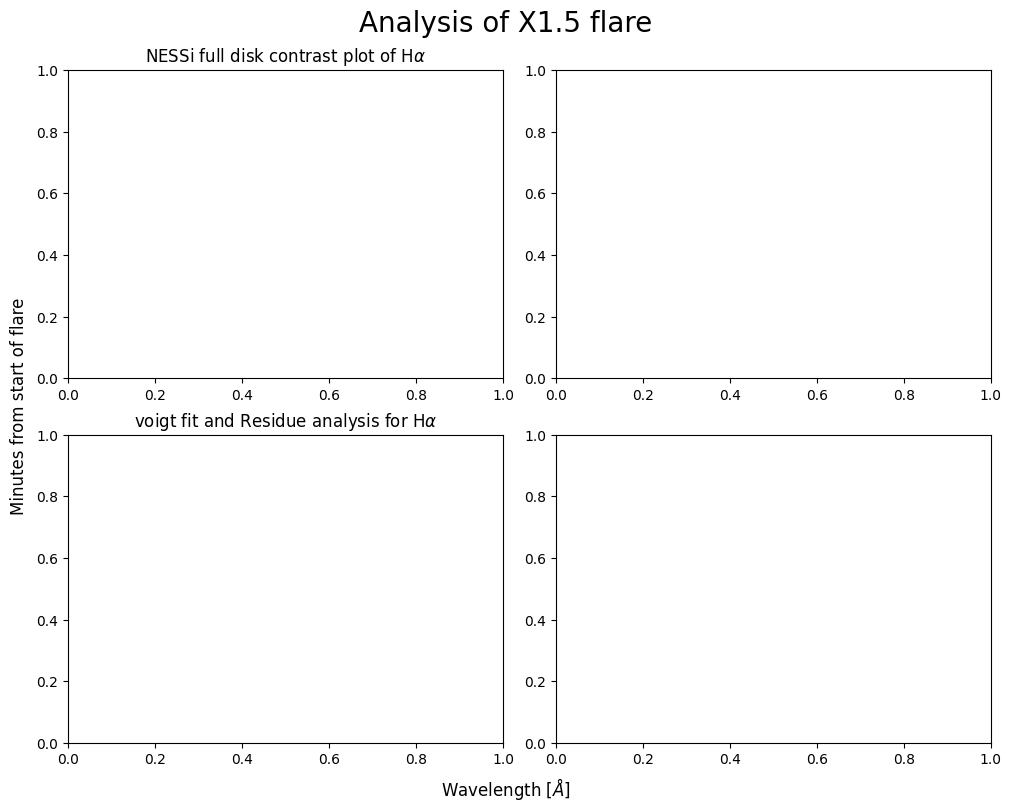

In [19]:
reload(un)
reload(un2)
# lines
lines = ["Ha14"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of X1.5 flare"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare")
fig.supxlabel(r"Wavelength [$\AA$]")


for i, name in enumerate(lines):
    ax[0,i].set_title(f"NESSi full disk contrast plot of {latex_name(name)}")
    ax[1,i].set_title(f"voigt fit and Residue analysis for {latex_name(name)}")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voig residues and Mu plot

scalefactor = round(10,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title}.png')

# C2.2

scaled flare: Line CaIR19
plotting element CaIR name: CaIR19
the special flare
vmax = 4.18616571320697e-08, vmin = -1.7996180125292375e-08
scaled flare: Line Fe6173_2019
plotting element Fe6173 name: Fe6173_2019
the special flare
vmax = 3.151504779479155e-08, vmin = -1.4728172946666703e-08
scaled flare: Line CaK19
plotting element CaK name: CaK19


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_17376\4152015331.py:94: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))



    \begin{figure*}
        \centering
        \includegraphics[width=1\linewidth]{Full_analysis_plots/Analysis of C2.0 flare}
        \caption{
    \textbf{The full Analysis of C2.0 flare:} NESSI calculated full disk profiles 
    for ~91\% flare capture. \textbf{Upper left 3:} 
    Contrastprofiles to the quiet sun for the lines \CaIR, \Fe{6173} and \CaK.
    \textbf{Lower left 3:} voigtprofile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:}  
    Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot 
    of the FOV in the \CaIR line overlayed with contour lines of the $\mu$-value. 
    }
        \label{fig:C2.0}
    \end{figure*}
    


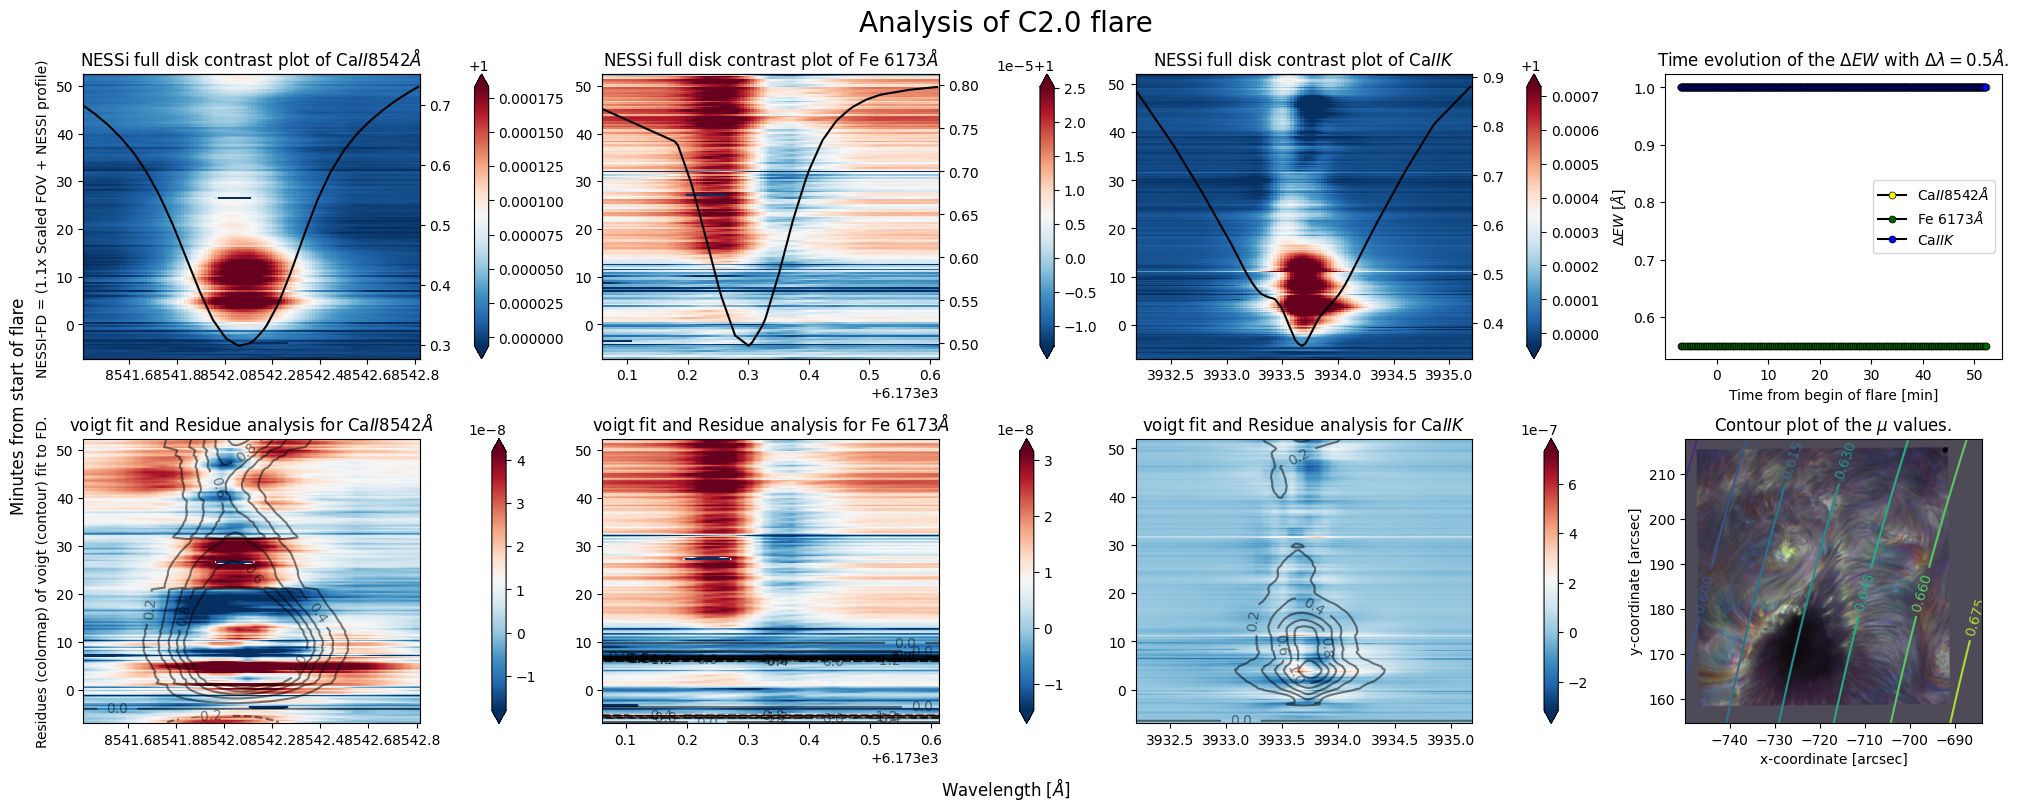

In [20]:
# lines
lines = ["CaIR19", "Fe6173_2019", "CaK19"]
qs_sub = [False, False, False]
long_names = {"Fe6173_2019":r"Fe 6173", "CaK19":r'Ca$IIK$', "CaIR19":r'Ca$II 8542 \AA$'}
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C2.0 flare"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel(f"Minutes from start of flare")
fig.supxlabel(r"Wavelength [$\AA$]")


for i, name in enumerate(lines):
    ax[0,i].set_title(f"NESSi full disk contrast plot of {latex_name(name)}")
    ax[1,i].set_title(f"voigt fit and Residue analysis for {latex_name(name)}")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(1/0.9,1) 
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title}.png')


**Figure Description**: \textbf{The full Analysis of the C2.2 flare:} NESSI calculated full disk profiles for full flare capture. \textbf{Upper left 3:} Contrastprofiles to the quiet sun for the lines \Halpha, \CaK and \CaIR. \textbf{Lower left 3:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \CaIR line overlayed with contour lines of the $\mu$-value. 


**In text notice**: For the X2.2 the full flare analysis is plotted in \autoref{} in the same way as was done for the X9.3 flare, assuming $60\%$ capture of the flare. 
The only line \Halpha encountered an increase of $0.06\%$. The contrast plots show a smooth decay of the inensity with a bit of variance in the left wing. In general the wings are quiet strong in absorption. The DEW experience a sharp dip before the start of the flare. The maxima in the DEW are matched with the stronger emmission profiles in the contrast profiles in the top left plot and the contourlines underneath. The telluric is again present. 

# M1.1 Flare 

dict_keys(['FOV_Ha14a', 'quiet_sun_Ha14a', 'nessi_Ha14a', 'TIME_Ha14a', 'FOV_CaIR14a', 'quiet_sun_CaIR14a', 'nessi_CaIR14a', 'TIME_CaIR14a'])
the correction factor is 0.5443367005895209
scaled flare: Line Ha14a
plotting element Ha name: Ha14a
vmax = 0.0002980455729574778, vmin = -9.044013196193703e-05
the correction factor is 0.7073079163644185
scaled flare: Line CaIR14a
plotting element CaIR name: CaIR14a
vmax = 0.0002870883362335013, vmin = -7.995472002307376e-05
the correction factor is 0.5443367005895209


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9648\892726769.py:96: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))


the correction factor is 0.7073079163644185

    \begin{figure*}
        \centering
        \includegraphics[width=1\linewidth]{Full_analysis_plots/Analysis of M1.1 flare}
        \caption{
    \textbf{The full Analysis of M1.1 flare:} NESSI calculated full disk profiles 
    for ~25\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR.
    \textbf{Lower left 2:} Voight profile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:}  
    Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot 
    of the FOV in the \Halpha line overlayed with contour lines of the $\mu$-value. 
    }
        \label{fig:M1.1}
    \end{figure*}
    


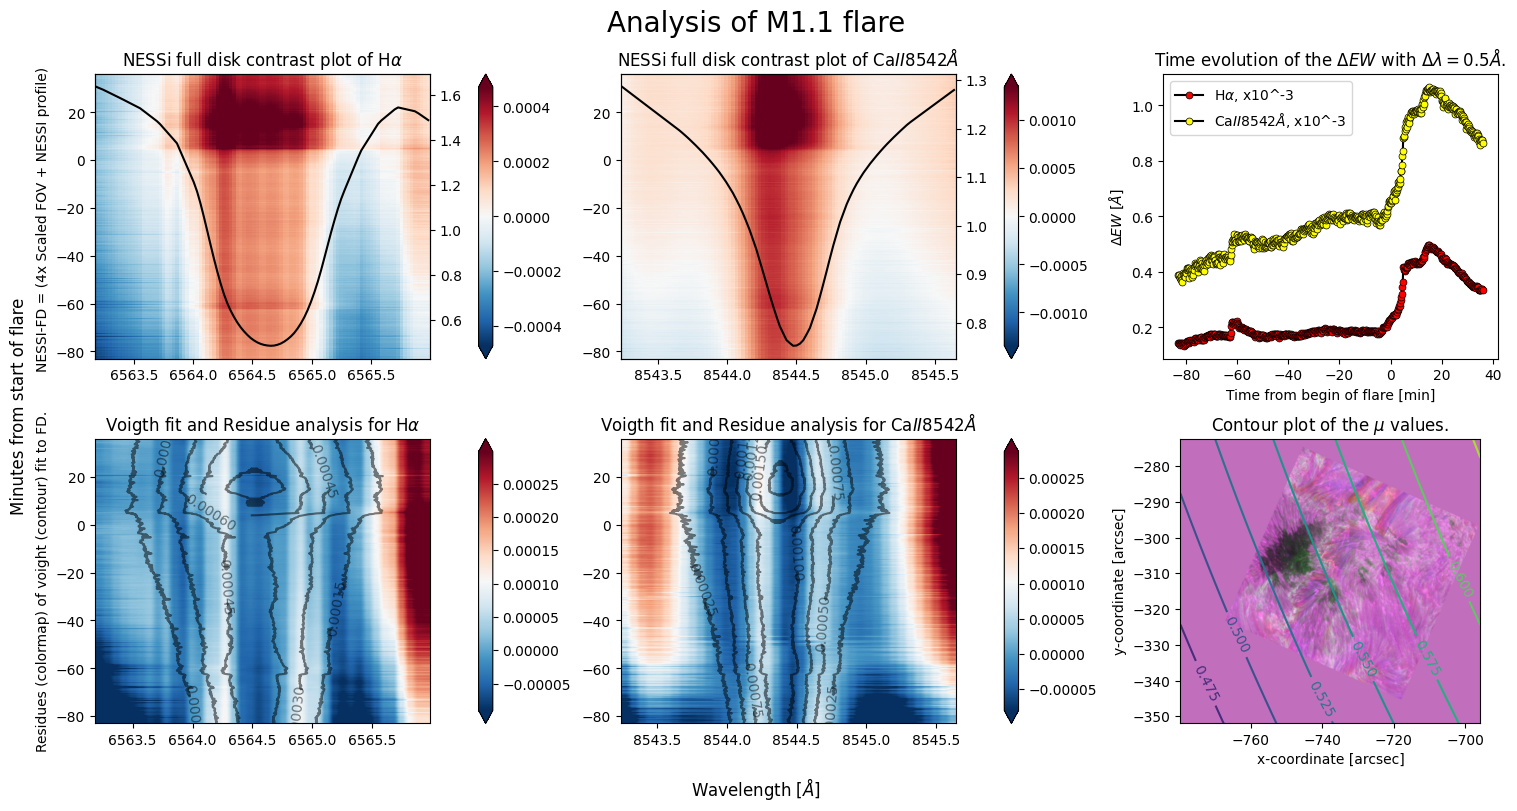

In [ ]:
reload(un)
reload(un2)
lines = ["Ha14a", "CaIR14a"]
long_names = {"Ha":r"H$\alpha$", "CaK":r'Ca$IIK$', "CaIR":r'Ca$II 8542 \AA$', "Hbeta":r'H$\beta$'}


data = un.load_for_further_analysis(lines, full_path = "E:/solar flares/data/2014-09-06/")
print(data.keys())


# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of M1.1 flare"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare")
fig.supxlabel(r"Wavelength [$\AA$]")


for i, name in enumerate(lines):
    ax[0,i].set_title(f"NESSi full disk contrast plot of {latex_name(name)}")
    ax[1,i].set_title(f"voigt fit and Residue analysis for {latex_name(name)}")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = round(4,1)
Full_line_ana(fig, ax, lines, scalefactor, data=data, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title}.png')

# C1.7 Flare

dict_keys(['FOV_Hbeta17a', 'quiet_sun_Hbeta17a', 'nessi_Hbeta17a', 'TIME_Hbeta17a', 'FOV_CaIR17a', 'quiet_sun_CaIR17a', 'nessi_CaIR17a', 'TIME_CaIR17a'])
the correction factor is 0.23217811789439047
scaled flare: Line Hbeta17a
plotting element Hbeta name: Hbeta17a
the correction factor is 0.2725799420410543
scaled flare: Line CaIR17a
plotting element CaIR name: CaIR17a
vmax = 1.2128584963621944e-05, vmin = -1.816438764392495e-05
the correction factor is 0.23217811789439047


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9648\892726769.py:96: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9648\892726769.py:221: RuntimeWarning: invalid value encountered in arcsin
  return np.cos(np.arcsin(rad_dist))


the correction factor is 0.2725799420410543

    \begin{figure*}
        \centering
        \includegraphics[width=1\linewidth]{Full_analysis_plots/Analysis of C1.7 flare}
        \caption{
    \textbf{The full Analysis of C1.7 flare:} NESSI calculated full disk profiles 
    for ~83\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the lines \Hbeta and \CaIR.
    \textbf{Lower left 2:} Voight profile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:}  
    Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot 
    of the FOV in the \Hbeta line overlayed with contour lines of the $\mu$-value. 
    }
        \label{fig:C1.7}
    \end{figure*}
    


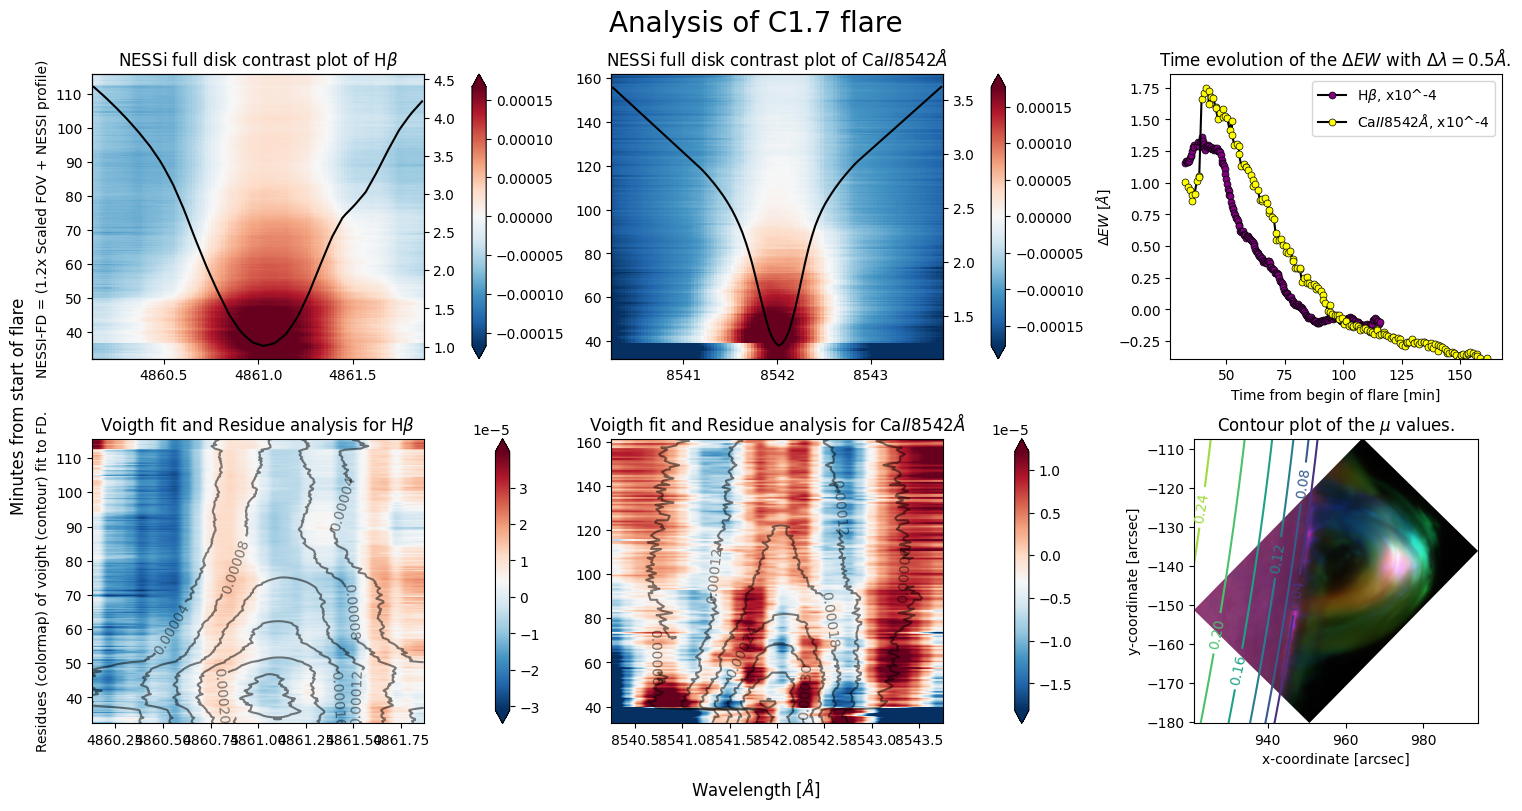

In [ ]:
reload(un)
reload(un2)
lines = ["Hbeta17a", "CaIR17a"] #], "CaK17a"]
long_names = {"Ha":r"H$\alpha$", "CaK":r'Ca$IIK$', "CaIR":r'Ca$II 8542 \AA$', "Hbeta":r'H$\beta$'}


data = un.load_for_further_analysis(lines, full_path = "E:/solar flares/data/2017-09-10/")
print(data.keys())
# un2.disgard_cont_point("CaK17a", data)
# un2.split_data_in_two_lines("CaK17a", data, 3950, lines)




# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C1.7 flare"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*4,4*rows/cols), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare")
fig.supxlabel(r"Wavelength [$\AA$]")


for i, name in enumerate(lines):
    ax[0,i].set_title(f"NESSi full disk contrast plot of {latex_name(name)}")
    ax[1,i].set_title(f"voigt fit and Residue analysis for {latex_name(name)}")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(1/0.8,1)
Full_line_ana(fig, ax, lines, scalefactor, data=data, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title}.png')

# Analysis of X9.3 flare

scaled flare: Line Ha17
plotting element Ha name: Ha17
vmax = 5.407434372519925e-07, vmin = -5.789312210213091e-08
scaled flare: Line CaK17
plotting element CaK name: CaK17
scaled flare: Line CaII17
plotting element CaIR name: CaII17
vmax = 2.0068330706889027e-07, vmin = -1.9684287642855596e-07


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_14300\1592402086.py:94: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))



    \begin{figure*}
        \centering
        \includegraphics[width=1\linewidth]{Full_analysis_plots/Analysis of X9.3 flare}
        \caption{
    \textbf{The full Analysis of X9.3 flare:} NESSI calculated full disk profiles 
    for ~40\% flare capture. \textbf{Upper left 3:} 
    Contrastprofiles to the quiet sun for the lines \Halpha, \CaK and \CaIR.
    \textbf{Lower left 3:} Voight profile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:}  
    Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot 
    of the FOV in the \Halpha line overlayed with contour lines of the $\mu$-value. 
    }
        \label{fig:X9.3}
    \end{figure*}
    


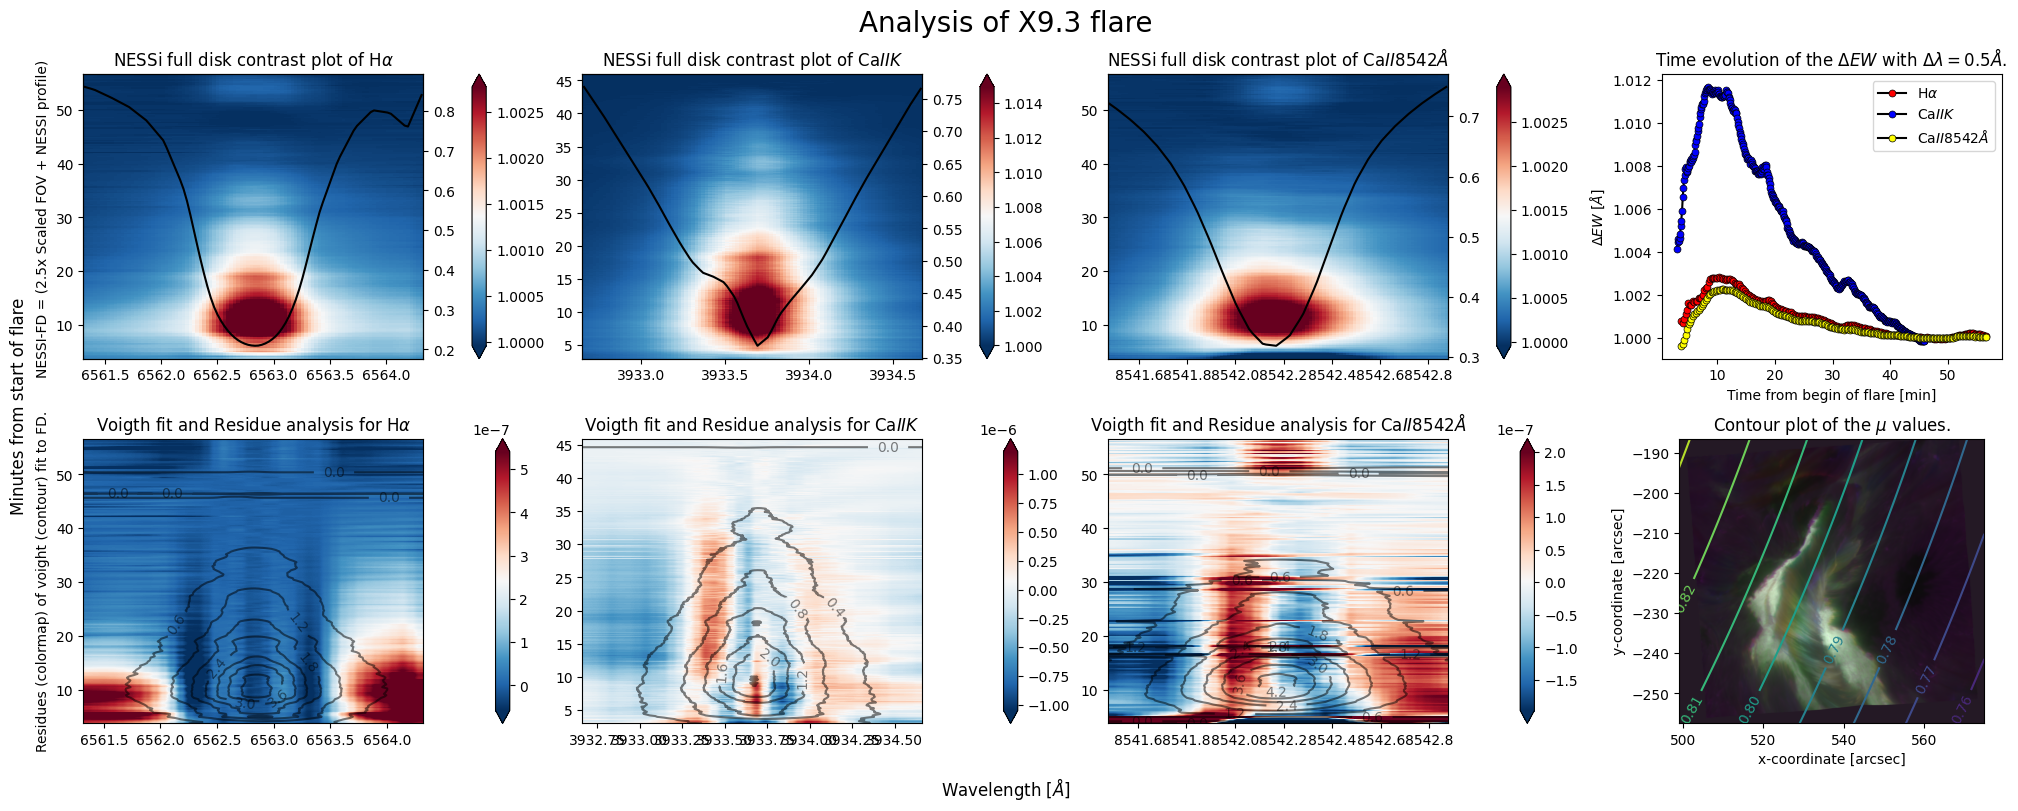

In [ ]:

# lines
lines = ["Ha17", "CaK17", "CaII17"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of X9.3 flare"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare")
fig.supxlabel(r"Wavelength [$\AA$]")


for i, name in enumerate(lines):
    ax[0,i].set_title(f"NESSi full disk contrast plot of {latex_name(name)}")
    ax[1,i].set_title(f"voigt fit and Residue analysis for {latex_name(name)}")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(5/2,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title}.png')

**Figure Description**: \textbf{The full Analysis of the X9.3 flare:} NESSI calculated full disk profiles for ~40% flare capture. \textbf{Upper left 3:} Contrastprofiles to the quiet sun for the lines \Halpha, \CaK and \CaIR. \textbf{Lower left 3:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line overlayed with contour lines of the $\mu$-value. 

Full analysis of the X9.3 flare. For the Available lines \Halpha, \CaIR and \CaK the three discussed methods of analysis are applied: NESSI generate virtual full disc spectum shown in the upper row, voigt fit and residue




**In text notice**: For the X9.3 the flare analysis we have preformed is plotted in \autoref{}. 
Here the full disk profiles are calculated by NESSI for the 3 availble lines \Halpha, \CaK and \CaIR and shown in the upper tree contrast profiles. The FOV of the SST captured 
approximately 40% of the flare area so we scaled by 
The difference to quiet spectrum normalized is displayed so a 0.15% increase in \Halpha, 1.5% increase in \CaK and 0.4% increase in \CaIR is found mostely in the line center.
It appears that the width of the broadening is comparable to the line width. We fitted this intensity increase with a voigt profile and in the lower 3 maps the shape of the 
voigt profiles is shown with contour lines.  By the voigt countour lines the peak of and the decrease after the flare even more clear than in the displays above.  The residues of this fitting are plotted in the same plots with a color map, which showing the intensity with pure thermal increase subtracted. In this way the telluric in \Halpha is a prominent feature and a slightly increasing absorption in the left wing after the flare can be observed as wel (\textbf{What does this mean?}).
In \CaK we observe a rather strong change in absorption and emission in the line center, which might be caused by the line shape of \CaK. Other features are an increasing absorption in the left wing analogous to \Halpha and the slowly decaying emmission in the right wing, which might be a sign of coronal rain?????? In \CaIR the horizontal oddity of voigt fits and residues is not caused by misfitting but is truely caused by the flare. Although the fit is at the start of the flare is somewhat more uncertain the shape of the voigt profiles are quiet consistent in time and thus the rather strong increase in the right wing and left center are by the nature of the flare. The minor features from \CaK are here observed as well: an increasing absorption in the left wing and the slowly decaying emmission in the right wing. For the differential equivalent width (DEW) are plotted in the rigth upper corner and are a measure of the increase of intensity as shown before by \citet{Otsu}. The 3 lines beheave similar during the evolution in their respective DEW where we see a peak around 5 minutes followed by a slowing decay. 

In [ ]:
# saving this data for collaboration
def saving_Full_line_ana(names_of_lines_list, scalefactor, name_of_flare="X9.3"):
    data = get_data(names_of_lines_list)
    for name in names_of_lines_list:
        wav, DFD , time, line, std = un2.contrast_FD_data(name,data, quiet_sun_subtraction=False, area_factor=area_factor*scalefactor, normal=True, add_noise=False)
        print(np.shape(wav))
        params, voigt, res = load_voigt_data(name, wav)
        c = area_factor*scalefactor
        
        filename = f"data/data_{name}_{name_of_flare}_voigt_residue_analysis.npz"

        np.savez(filename, time, wav, DFD, std, c*params, c*res)
        
        

# lines
lines = ["Ha17", "CaK17", "CaII17"]
flare_name = "X9.3"
scalefactor = round(5/2,1)

# saving_Full_line_ana(lines, scalefactor, name_of_flare=flare_name)

data_structure = """
Discription of "data_{name}_{name_of_flare}_voigtresidue_analysis.npz" file:
arr_0:  time        time in minutes from the start of the flare (as in solar monitor or tabel below.)
arr_1:  wav         wavelength positions in angstrom
arr_2:  DFD         Difference intencity for Full Disk synthesized spectrum compared to quiet full disk spectrum (time x wav- array)
arr_3:  std         Standard deviation in spectral position for DFD (wav - array)
arr_4:  params      voig fit parameters in time. the 4 parameters are amplitude, center, sigma, gamma. See below for implementation (time x 4 -array)
arr_5:  res         Residues to the voigt fit in time. (time x wav - array)


def gaussian(x, amp_g, cen_g, sigma_g):
    # Gaussian function.
    return amp_g * np.exp(-(x - cen_g)**2 / (2 * sigma_g**2))

def lorentzian(x, amp_l, cen_l, gamma_l):
    # Lorentzian function.
    return amp_l * (gamma_l**2 / ((x - cen_l)**2 + gamma_l**2))

def voigt(x, param, offset=0):
    # Voigt profile: approximation by combining Gaussian and Lorentzian.
    amp_v, cen_v, sigma_v, gamma_v = param
    f_g = sigma_v**2 / (sigma_v**2 + gamma_v**2)
    return (f_g * gaussian(x, 1, cen_v, sigma_v) +
            (1 - f_g) * lorentzian(x, 1, cen_v, gamma_v)) * amp_v + offset
            
            
\\begin{table*}[ht]
    \centering
    \caption{Flare Information}
    \label{tab:flare_info} 
    \\begin{tabular}{llllllllll}
        \\toprule
        Year & NOAA & Class & Start/Stop/Peak & SST Start/Stop & Overlap & (X, Y) & $\mu$ & Lines & Cad [s] \\
        \midrule
        2017-09-06 &  12673 & X9.3 &11:53/12:10/12:01 &11:56/12:52 & appr 40\% & (513'', -216'') & 0.815 & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0  \\ & & & & & & & & \CaK & 6.6 \\
        2017-09-06 & 12673 & X2.2 & 8:57/9:17/09:09 &09:04/09:54 & appr 60\% & (542'', -208'') & 0.803 & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0 \\ & & & & & & & & \CaK & 6.6 \\ 
        2015-06-24 &  12371 & C5.6&	15:12/15:40/15:29 &-/- &  & (496'', 175'') &  & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0  \\
        2011-08-06 &  	11267 & C4.1 &08:37/08:51/08:47 &-/- & appr 40\% & (S17 E12) & 0.815 & \CaIR & 15.0 \\ & & & & & & & & \Halpha & 15.0  \\ & & & & & & & & \CaK & 6.6 \\
        2019-05-06 &12740 & C2.0  &08:41/08:51/08:47 &08:34/09:33&&(-716.9'', 186.2'')& 0.638 & \Fe6173 & 20.9 \\ & & & & & & & & \CaIR  & 20.9\\ & & & & & & & & \CaK & 7.8 \\ 
        2013-06-30 & 11778 & C1.3 &09:11/09:27/09:18 &09:16/10:17&100\%&(323.4'', -287.9'')& 0.892 & \Halpha        & 7.3  \\
        \\bottomrule
    \end{tabular}
\end{table*}
"""


# Open the file in write mode ('w') and write content
with open("data/data_description.txt", "w") as file:
  file.write(data_structure)

print("Text file saved successfully!")



Text file saved successfully!


# X2.2 flare 

the correction factor is 0.7178257412287012
scaled flare: Line Ha17_9u
plotting element Ha name: Ha17_9u
vmax = 8.563993477711396e-05, vmin = -4.475876993759046e-05
the correction factor is 0.7178257412287012


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9648\47948294.py:96: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))



    \begin{figure*}
        \centering
        \includegraphics[width=1\linewidth]{Full_analysis_plots/Analysis of X2.2 flare}
        \caption{
    \textbf{The full Analysis of X2.2 flare:} NESSI calculated full disk profiles 
    for ~59\% flare capture. \textbf{Upper left:} 
    Contrastprofiles to the quiet sun for the lines \Halpha.
    \textbf{Lower left:} Voight profile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:}  
    Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot 
    of the FOV in the \Halpha line overlayed with contour lines of the $\mu$-value. 
    }
        \label{fig:X2.2}
    \end{figure*}
    


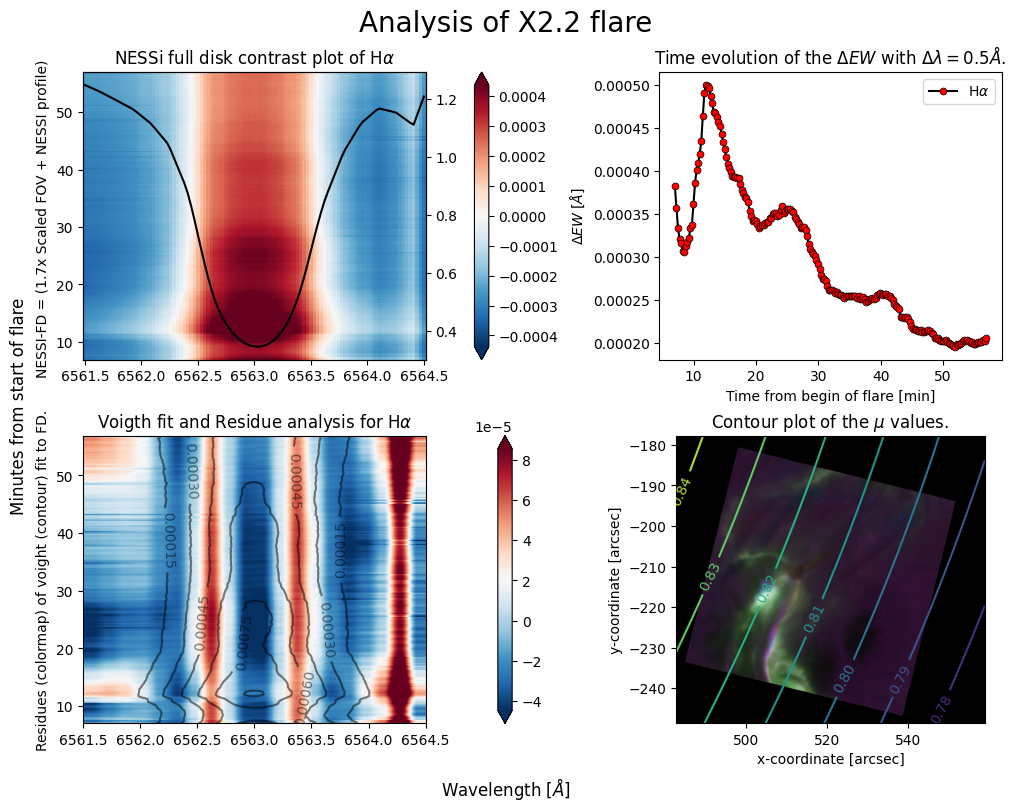

In [ ]:
# lines
lines = ["Ha17_9u"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of X2.2 flare"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel(f"Minutes from start of flare")
fig.supxlabel(r"Wavelength [$\AA$]")


for i, name in enumerate(lines):
    ax[0,i].set_title(f"NESSi full disk contrast plot of {latex_name(name)}")
    ax[1,i].set_title(f"voigt fit and Residue analysis for {latex_name(name)}")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = round(1/0.6,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title}.png')

**Figure Description**: \textbf{The full Analysis of the X2.2 flare:} NESSI calculated full disk profiles for ~60% flare capture. \textbf{Upper left:} Contrastprofiles to the quiet sun for the available line \Halpha. \textbf{Lower left:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line at the start of the flare overlayed with contour lines of the $\mu$-value. 



**In text notice**: For the X2.2 the full flare analysis is plotted in \autoref{} in the same way as was done for the X9.3 flare, assuming $60\%$ capture of the flare. 
The only line \Halpha encountered an increase of $0.05\%$. The contrast plots show a smooth decay of the inensity with a bit of variance in the left wing. In general the wings are quiet strong in absorption. The DEW experience a sharp dip before the start of the flare. The maxima in the DEW are matched with the stronger emmission profiles in the contrast profiles in the top left plot and the contourlines underneath. The telluric is again present. 

# C1.3

the correction factor is 0.8821712151803175
scaled flare: Line Ha13
plotting element Ha name: Ha13
vmax = 0.00016565192098162102, vmin = -2.3182620583856262e-05
the correction factor is 0.8821712151803175


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9648\47948294.py:96: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))



    \begin{figure*}
        \centering
        \includegraphics[width=1\linewidth]{Full_analysis_plots/Analysis of C1.3 flare}
        \caption{
    \textbf{The full Analysis of C1.3 flare:} NESSI calculated full disk profiles 
    for ~100\% flare capture. \textbf{Upper left:} 
    Contrastprofiles to the quiet sun for the lines \Halpha.
    \textbf{Lower left:} Voight profile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:}  
    Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot 
    of the FOV in the \Halpha line overlayed with contour lines of the $\mu$-value. 
    }
        \label{fig:C1.3}
    \end{figure*}
    


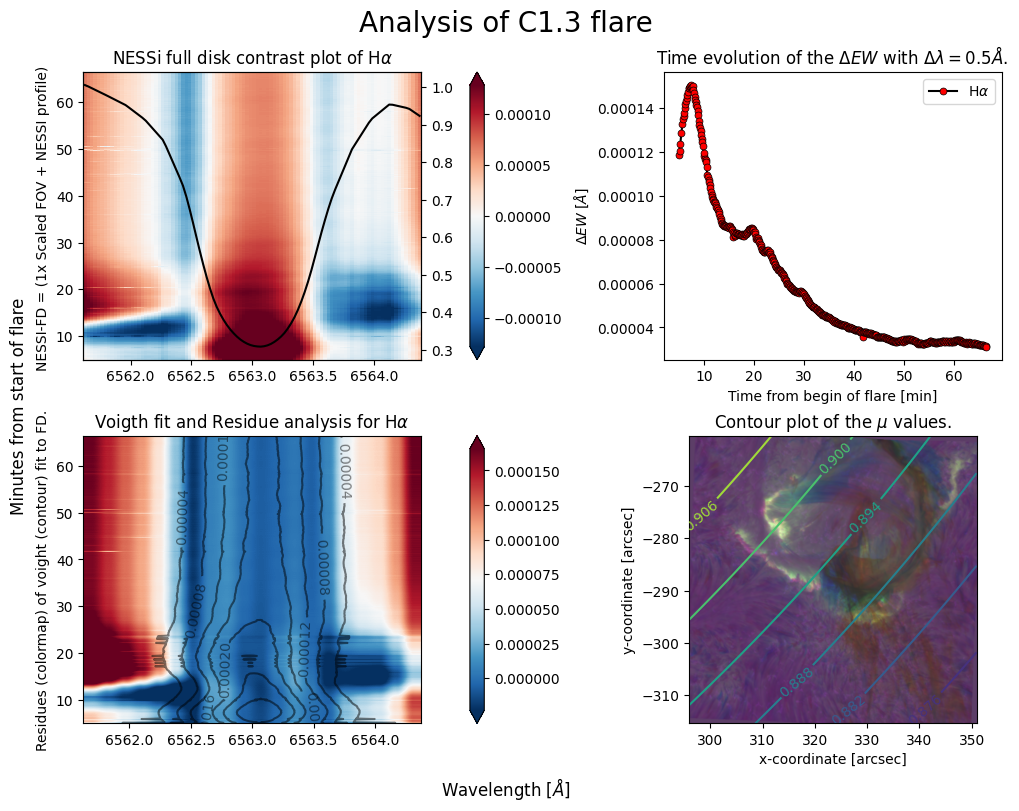

In [ ]:
# lines
lines = ["Ha13"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C1.3 flare"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel(f"Minutes from start of flare")
fig.supxlabel(r"Wavelength [$\AA$]")


for i, name in enumerate(lines):
    ax[0,i].set_title(f"NESSi full disk contrast plot of {latex_name(name)}")
    ax[1,i].set_title(f"voigt fit and Residue analysis for {latex_name(name)}")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = round(1,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title}.png')

**Figure Description**: \textbf{The full Analysis of the C1.3 flare:} NESSI calculated full disk profiles for assumed full flare capture. \textbf{Upper left:} Contrastprofiles to the quiet sun for the lines \Halpha. \textbf{Lower left:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line at the start of the flare overlayed with contour lines of the $\mu$-value. 


**In text notice**: For the C1.3 full capture of the flare is assumed. The full flare analysis is plotted in \autoref{} in the same way as was done for the previous flares.
The only available line \Halpha encountered an increase of $0.0001\%$. The contrast plots show a smooth and assymetric wiggling decay of the inensity. at 20 minutes into the flare the assymmetry is the stronges which has its cause in the amount of material ejected and hanging in the frame . 


# M1.9 Flare

the correction factor is 0.5141619971278732
scaled flare: Line Ha15a
plotting element Ha name: Ha15a
vmax = 0.00030112349175087335, vmin = -9.863051426591823e-05
the correction factor is 0.6043118247509953
scaled flare: Line CaIR15a
plotting element CaIR name: CaIR15a
vmax = 7.426841915379815e-05, vmin = -6.162056743171107e-05
the correction factor is 0.5141619971278732
the correction factor is 0.6043118247509953

    \begin{figure*}
        \centering
        \includegraphics[width=1\linewidth]{Full_analysis_plots/Analysis of M1.9 flare}
        \caption{
    \textbf{The full Analysis of M1.9 flare:} NESSI calculated full disk profiles 
    for ~30\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR.
    \textbf{Lower left 2:} Voight profile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:}  
    Differential Equival

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9648\892726769.py:96: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))


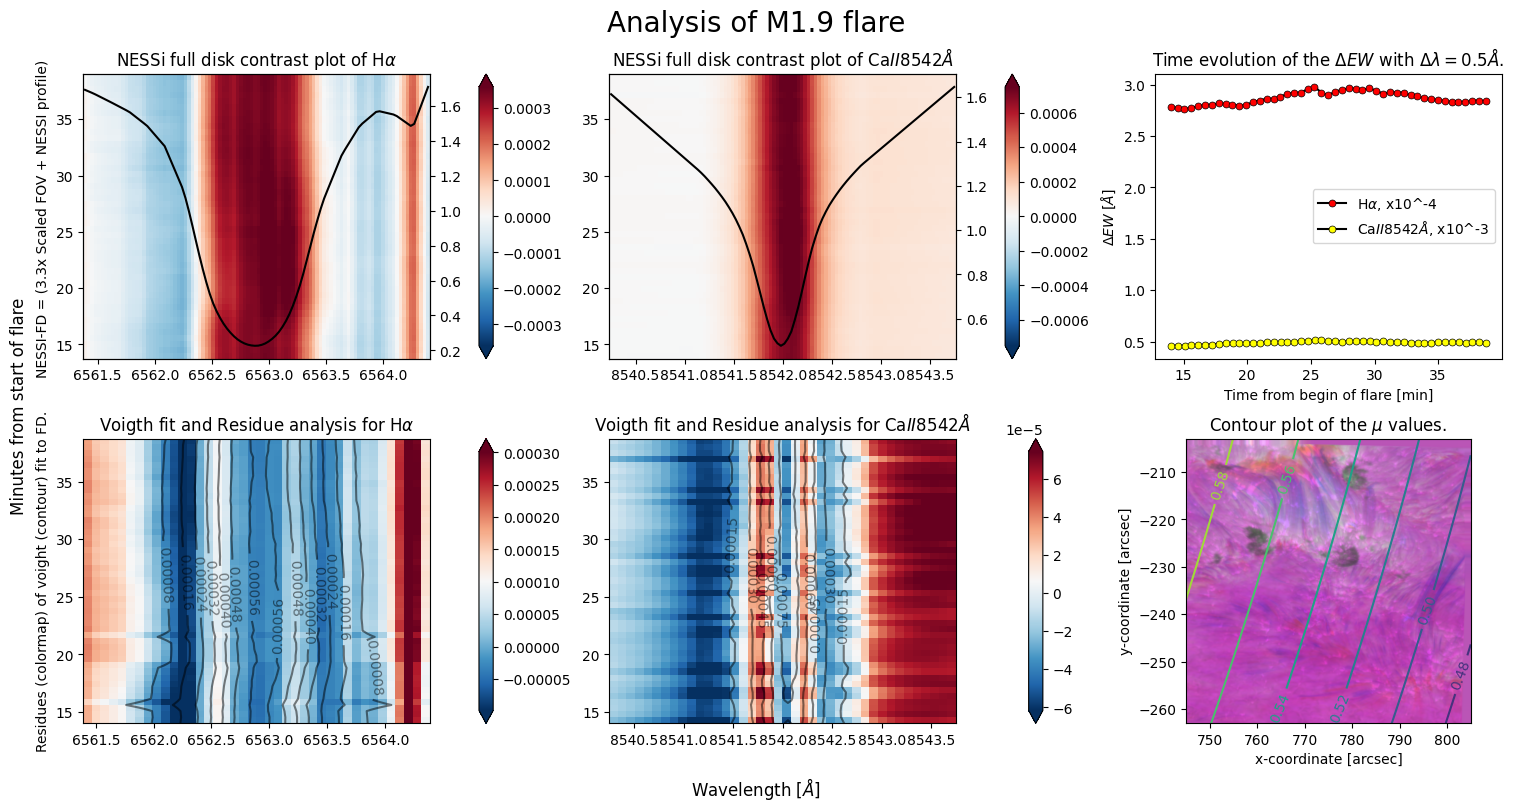

In [ ]:
reload(un)
# lines
lines = ["Ha15a", "CaIR15a"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of M1.9 flare"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare")
fig.supxlabel(r"Wavelength [$\AA$]")


for i, name in enumerate(lines):
    ax[0,i].set_title(f"NESSi full disk contrast plot of {latex_name(name)}")
    ax[1,i].set_title(f"voigt fit and Residue analysis for {latex_name(name)}")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigt residues and Mu plot

scalefactor = round(1/0.3,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title}.png')

# C5.6 2015

the correction factor is 0.5907719415655153
scaled flare: Line Ha15
plotting element Ha name: Ha15
vmax = 0.00018993097180708995, vmin = -0.00017705501814771935
the correction factor is 0.9533701253460637
scaled flare: Line CaIR15
plotting element CaIR name: CaIR15
vmax = 0.0004808670489394887, vmin = -0.0001199968572866258
the correction factor is 0.5907719415655153


C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9648\892726769.py:96: DeprecationWarning: The 'even' keyword is deprecated as of SciPy 1.11.0 and will be removed in SciPy 1.13.0
  DEW.append( scipy.integrate.simpson(y=restx(DFD[frame]), x=x, dx=1.0, axis=-1, even='avg'))


the correction factor is 0.9533701253460637

    \begin{figure*}
        \centering
        \includegraphics[width=1\linewidth]{Full_analysis_plots/Analysis of C5.6 flare}
        \caption{
    \textbf{The full Analysis of C5.6 flare:} NESSI calculated full disk profiles 
    for ~20\% flare capture. \textbf{Upper left 2:} 
    Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR.
    \textbf{Lower left 2:} Voight profile fits to the respective contrastprofiles above are 
    shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:}  
    Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot 
    of the FOV in the \Halpha line overlayed with contour lines of the $\mu$-value. 
    }
        \label{fig:C5.6}
    \end{figure*}
    


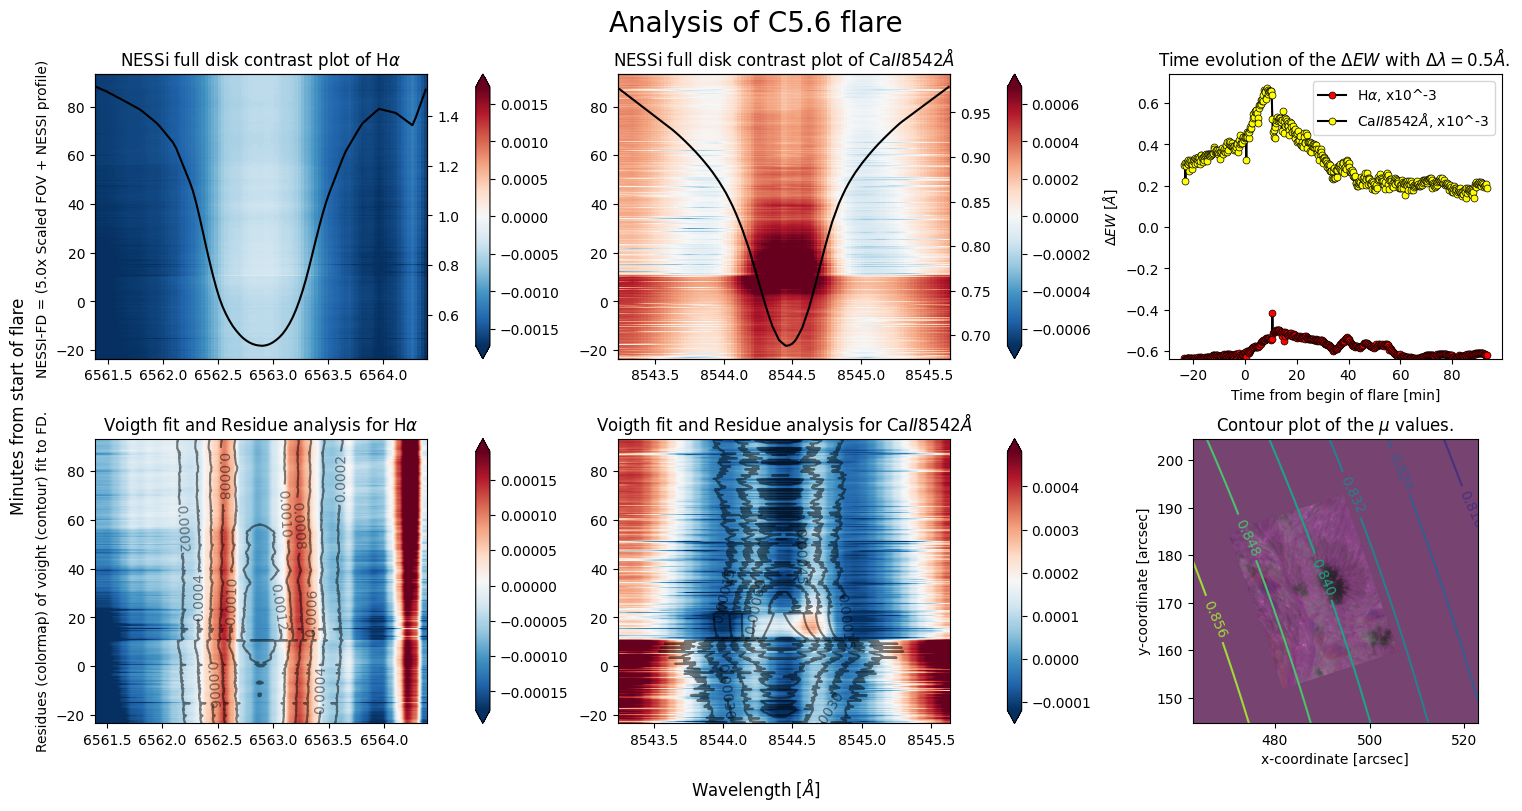

In [ ]:
reload(un)
# lines
lines = ["Ha15", "CaIR15"]
# rows: the different flares
rows = 2
# collumns: the differnt lines + DEW
cols = len(lines)+1
title = "Analysis of C5.6 flare"

# make figure
fig, ax = plt.subplots(rows, cols, figsize=(5*cols,4*rows), constrained_layout=True)
fig.suptitle(title, fontsize=20)
fig.supylabel("Minutes from start of flare")
fig.supxlabel(r"Wavelength [$\AA$]")


for i, name in enumerate(lines):
    ax[0,i].set_title(f"NESSi full disk contrast plot of {latex_name(name)}")
    ax[1,i].set_title(f"voigt fit and Residue analysis for {latex_name(name)}")


# row 1: Scaled contrast profiles + equivalent widths
# row 2: voigtresidues and Mu plot

scalefactor = round(5/1,1)
Full_line_ana(fig, ax, lines, scalefactor, name_of_flare=title)


fig.savefig(f'E:\solar flares\data\\full_analysis\Full_plots\{title}.png')

**Figure Description**: \textbf{The full Analysis of the C5.6 flare:} NESSI calculated full disk profiles for assumed full flare capture. \textbf{Upper left 2:} Contrastprofiles to the quiet sun for the lines \Halpha and \CaIR. \textbf{Lower left 2:} voigt profile fits to the respective contrastprofiles above are shown using a contourmap, the residues to those fitting are shown using a color map. \textbf{upper right:} Differential Equivalent Width of the available lines as a function of time. \textbf{Lower right:} A cocoplot of the FOV in the \Halpha line at the start of the flare overlayed with contour lines of the $\mu$-value. 


**In text notice**: For the C5.6 full capture of the flare is assumed. The full flare analysis is plotted in \autoref{} in the same way as was done for the previous flares.
\Halpha encountered an increase of $8e-3\%$ and \CaK en increase of $0.015\%$. The contrast profiles show clearly the peak of the flare. In \CaIR a sharp transition is made around 12 minutes into the flare, approximately the peak of the flare. This change is visible over the entire band. Both in \Halpha and in \CaIR the flare is accompagned with a strong increase in the line center. In later times steadily appearing emmission in the wings can be seen. It seems as if the Telluric is also growing in strenght after the flare has happend. 
The voigt profile analysis around the discontinuity of \CaIR shows a similar jump. It seems as if the flare dies of instantly after this point in \CaIR. The DEW experience a discontinuity at the same time.